<a href="https://colab.research.google.com/github/alibrj82/ChestX-ray8-final-/blob/main/ChestX_ray8_(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage.filters import gaussian, threshold_multiotsu, threshold_otsu
from skimage.morphology import closing, disk, remove_small_objects
from skimage.measure import label, regionprops


# Google Drive'ı Bağlama
drive.mount('/content/drive')

# Yolları Tanımlama
images_folder_path = '/content/drive/My Drive/ChestX-ray8/images1/images'
metadata_path = '/content/drive/My Drive/CXR8/Data_Entry_2017_v2020.csv'

# Metadata CSV dosyasını yüklemek
df = pd.read_csv(metadata_path)
print(df.shape)
print(df.head())  # DataFrame'in ilk birkaç satırını kontrol etmek
# Eksik değerleri kontrol etmek
print(df.isnull().sum())

# Benzersiz hasta sayısını saymak
unique_patients = df['Patient ID'].nunique()
print(f"Unique patients: {unique_patients}")

# Hastaların birden fazla görüntüye sahip olup olmadığını kontrol etmek
patient_image_count = df['Patient ID'].value_counts()
print(patient_image_count)


# Klasördeki görselleri doğrulama
images_in_folder = os.listdir(images_folder_path)
print(f"Total images in folder: {len(images_in_folder)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(112120, 11)
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F           

# Eksik değerleri

*   Veri kümesi meta verileri birden fazla sütun içeriyor ve hiçbirinde eksik değer bulunmuyor (tüm sütunlar için eksik giriş sayısı 0 olarak görünüyor). Tüm sütunlar tamamen dolu, bu da elimizde eksiksiz bir veri kümesi olduğunu gösteriyor. Eksik veriler için ön işleme yapılmasına gerek yok.
# Patient Id

*   Veri kümesi toplamda 30.805 benzersiz hastayı içermektedir. Örneğin, 10007 numaralı Hasta Kimliği 184 görüntüye sahipken, 13617, 13610 ve 13609 gibi bazı kimlikler yalnızca birer görüntüye sahiptir.
*   Bu durum, görüntü sayısı açısından dengesiz bir veri kümesi ortaya çıkarmaktadır.





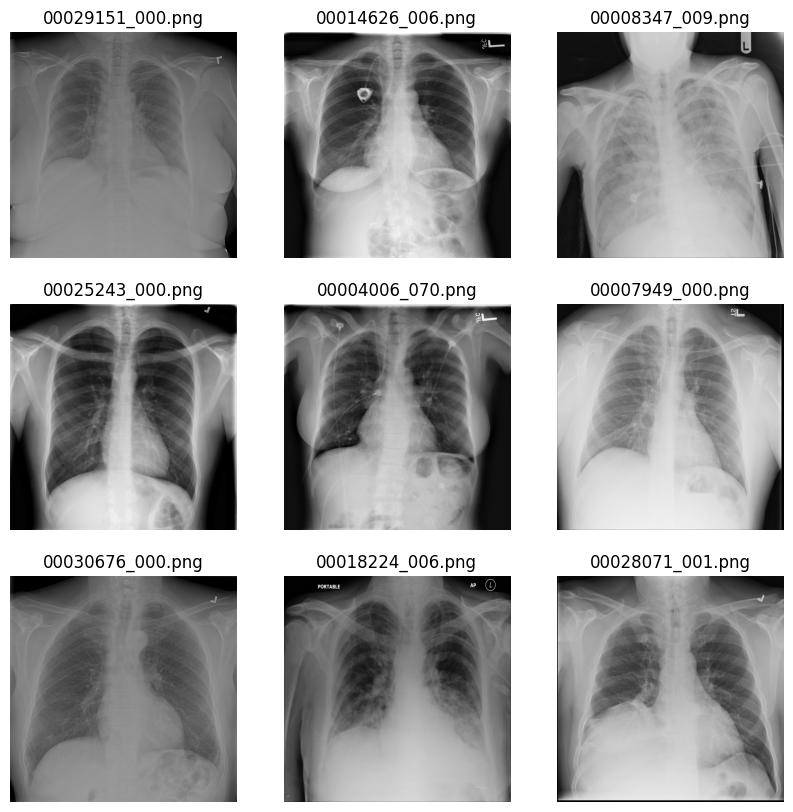

In [ ]:
# CSV dosyasından birkaç görsel örneği seçmek ve görüntülemeyi denemek.
sample_images = df['Image Index'].sample(9).values  # Rastgele 9 görüntü seçmek.

plt.figure(figsize=(10, 10))
for i, image_name in enumerate(sample_images):
    image_path = os.path.join(images_folder_path, image_name)

    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(image_name)
    else:
        print(f"Image {image_name} not found in folder.")

plt.show()


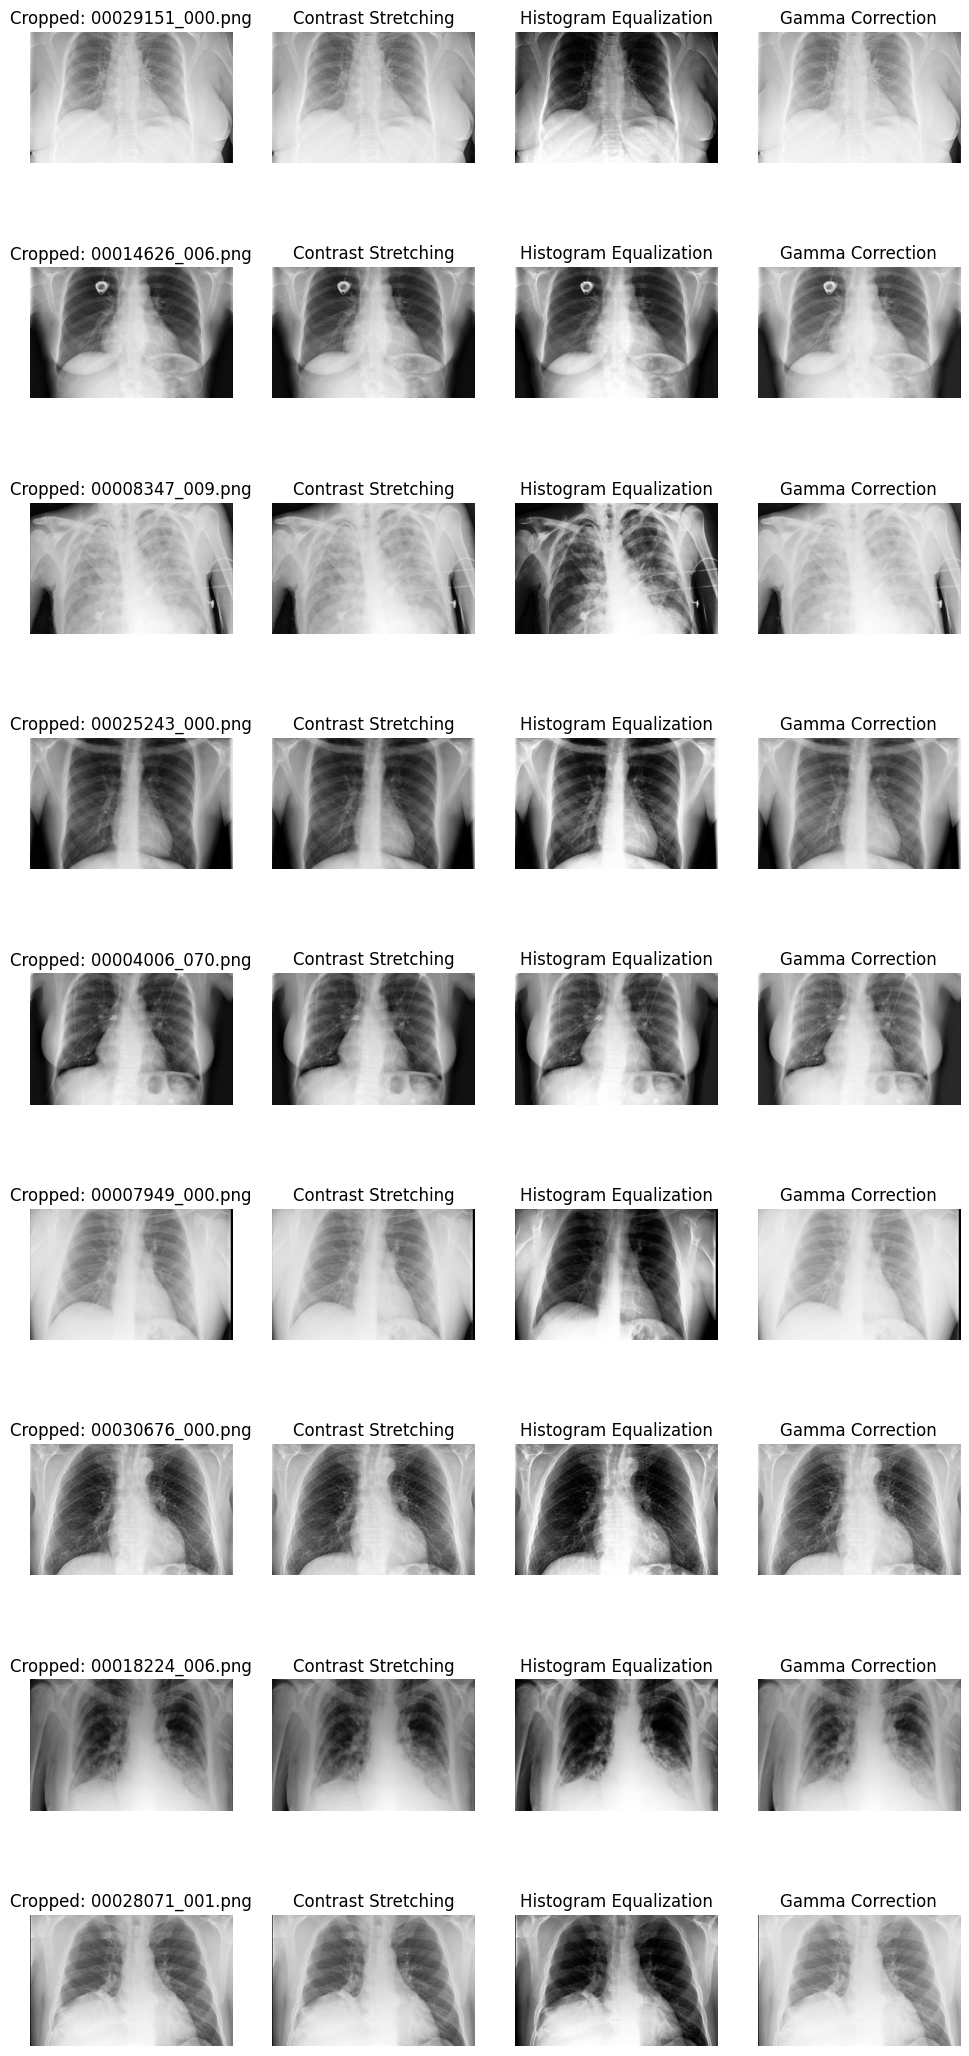

In [ ]:
# Bir sonraki adım için histogram eşitlenmiş görüntüleri depolamak için sözlük
hist_eq_images = {}

def refined_center_crop(image, base_fraction=0.7):

    h, w = image.shape  # Grayscale image (height, width)

    # Görüntü Yüksekliğine Dayalı Uyarlanabilir Kırpma Oranı
    crop_fraction = base_fraction + (0.1 if h > 2000 else -0.05)

    # Kırpma sınırlarını tanımlamak
    start_y = int(h * (1 - crop_fraction) / 2)
    end_y = int(h * (1 + crop_fraction) / 2)


    if end_y - start_y < h * 0.5:
        start_y = int(h * 0.25)
        end_y = int(h * 0.75)

    cropped_image = image[start_y:end_y, :]
    return cropped_image

def contrast_stretching(image):

    min_intensity = np.min(image)
    max_intensity = np.max(image)
    stretched = (image - min_intensity) * (255 / (max_intensity - min_intensity))
    return np.uint8(stretched)

def histogram_equalization(image):

    return cv2.equalizeHist(image)

def gamma_correction(image, gamma=1.5):

    gamma_table = np.array([(i / 255.0) ** (1 / gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, gamma_table)

# 9 seçili görüntüyü işle: Kırpma + Kontrast Geliştirme
num_images = len(sample_images)
plt.figure(figsize=(12, num_images * 3))

for i, image_name in enumerate(sample_images):
    image_path = os.path.join(images_folder_path, image_name)

    if os.path.exists(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Step 3.1: Cropping
        cropped_image = refined_center_crop(image)

        # Step 3.2: Contrast Enhancements
        stretched = contrast_stretching(cropped_image)
        equalized = histogram_equalization(cropped_image)
        gamma_corrected = gamma_correction(cropped_image, gamma=1.5)

        # Histogram eşitlenmiş görüntüyü bir sonraki adım için kayd etmek
        hist_eq_images[image_name] = equalized

        # Görüntüleri görüntüle: Kırpılmış ve Geliştirilmiş sürümler
        plt.subplot(num_images, 4, 4 * i + 1)
        plt.imshow(cropped_image, cmap='gray')
        plt.axis('off')
        plt.title(f"Cropped: {image_name}")

        plt.subplot(num_images, 4, 4 * i + 2)
        plt.imshow(stretched, cmap='gray')
        plt.axis('off')
        plt.title("Contrast Stretching")

        plt.subplot(num_images, 4, 4 * i + 3)
        plt.imshow(equalized, cmap='gray')
        plt.axis('off')
        plt.title("Histogram Equalization")

        plt.subplot(num_images, 4, 4 * i + 4)
        plt.imshow(gamma_corrected, cmap='gray')
        plt.axis('off')
        plt.title("Gamma Correction")
    else:
        print(f"Image {image_name} not found.")

plt.show()


**Merkez Kırpma (Center Cropping)**

Amaç:  
Görüntünün gereksiz bölümlerini kaldırarak akciğerlere odaklanmak.  

Kullanılan Teknikler:
*   Görüntü yüksekliğinin belirli bir oranını kullanarak uyarlanabilir kırpma
*   Göğüs bölgesine odaklanmak için görüntü yüksekliğinin %70'ini kırpma

Neden Bu Yöntem?
*   Orijinal görüntülerde akciğer analizi için gereksiz olan arka plan bölgeleri bulunuyor.
*   Uyarlanabilir kırpma, hem küçük hem de büyük görüntülerin doğru şekilde işlenmesini sağlıyor.  

Gözlemler:
*   Akciğer bölgeleri başarılı bir şekilde izole edildi.
*   Bazı görüntülerde hafif aşırı kırpma meydana geldi, ancak bu dinamik olarak ayarlandı.

**Kontrast Artırma (Contrast Enhancement)**

Amaç:
*   Röntgen görüntülerinin kontrastını iyileştirerek akciğer yapılarını daha net hale getirmek.  

Kullanılan Teknikler:
1.   Kontrast Germe (Contrast Stretching):Piksel yoğunluk değerlerini yeniden ölçeklendirerek kontrastı artırır.
2.   Histogram Eşitleme (Histogram Equalization):Piksel yoğunluklarını tam gri tonlama aralığına yayarak kontrastı iyileştirir.
3.   Gama Düzeltme (Gamma Correction): Gama değeri (γ=1.5) kullanılarak parlaklık ve kontrast ayarlanır.

Neden Histogram Eşitleme Seçildi?
*   Histogram eşitleme, akciğer yapılarını en iyi şekilde belirginleştirdi.
*   Gama düzeltme, aşırı parlaklığa neden oldu.
*   Kontrast germe, yeterince etkili olmadı.

Gözlemler:
*   Akciğer özelliklerini netleştirdiği için **Histogram Eşitleme**, sonraki adımlarda kullanılmak üzere seçildi.
*   Diğer yöntemler karşılaştırma amacıyla kaydedildi.





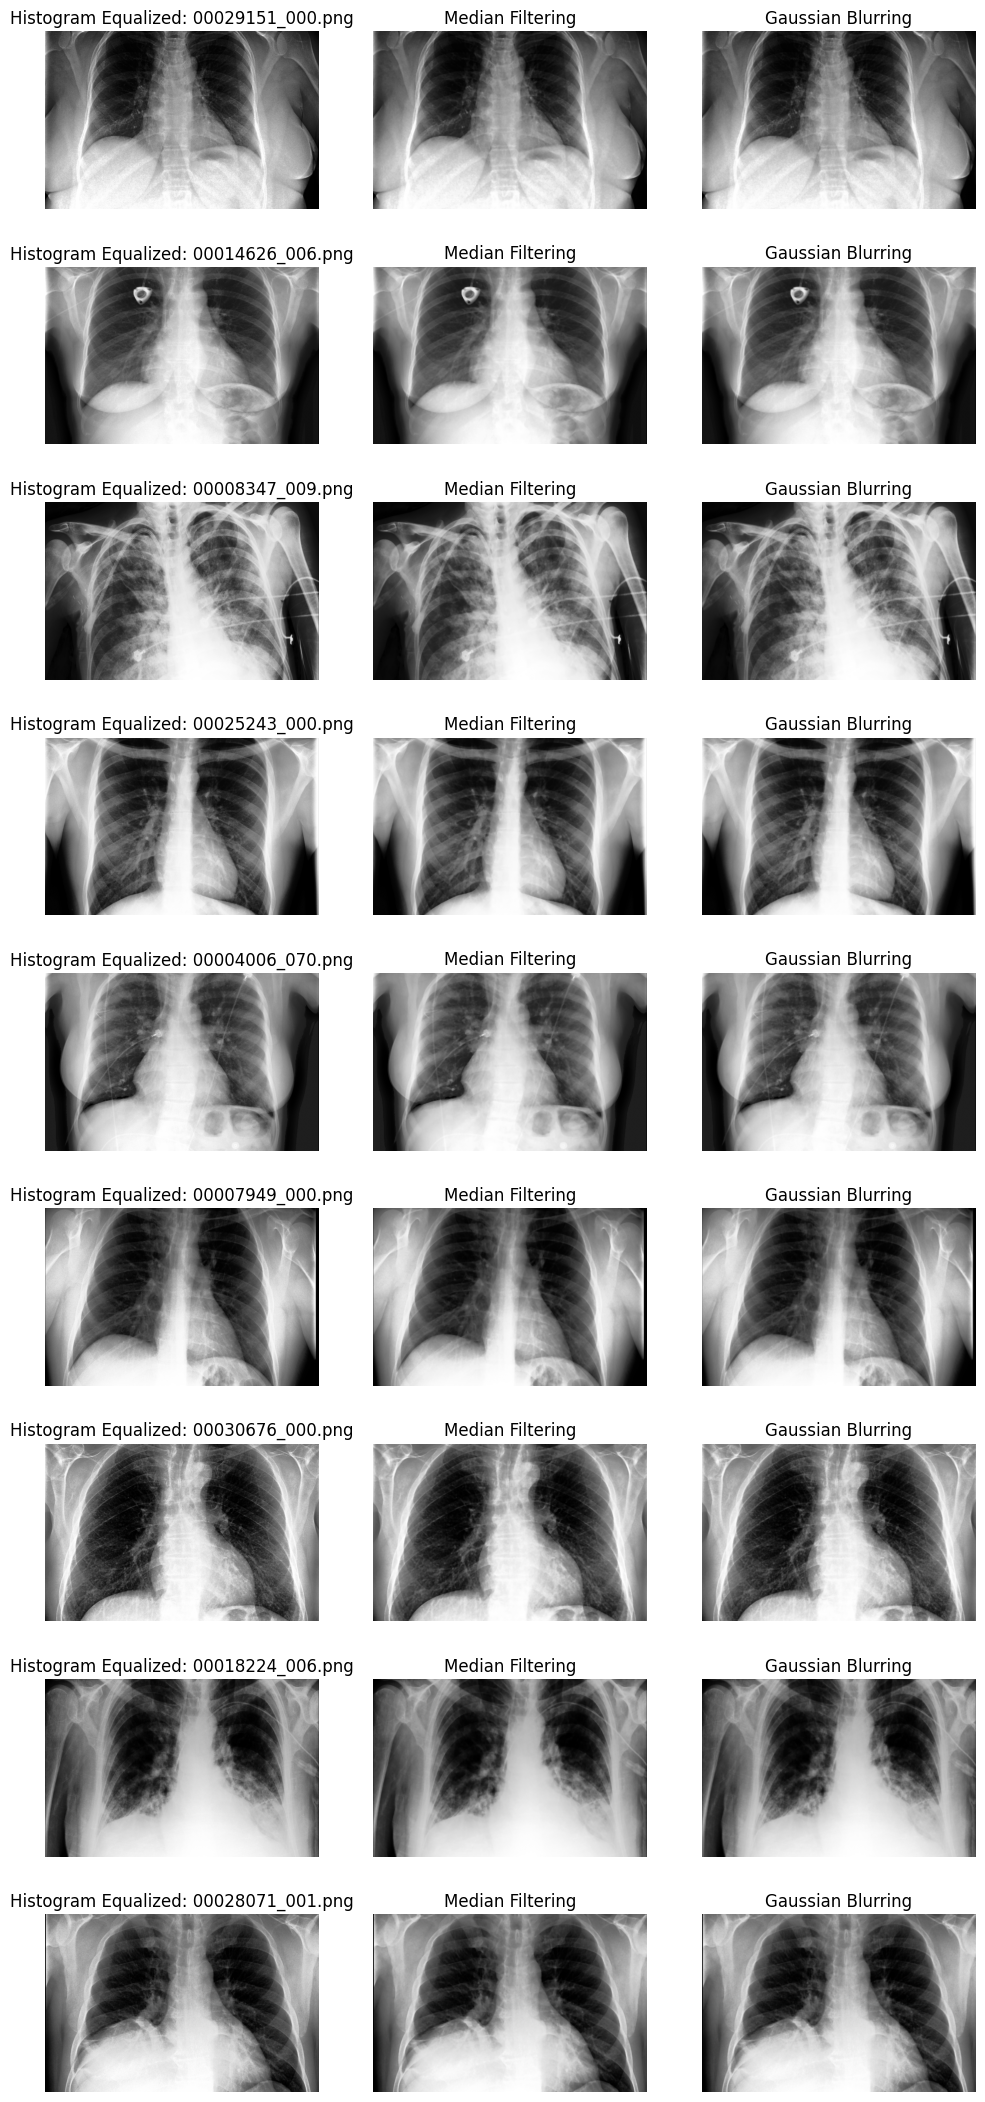

In [ ]:
# Bir sonraki adım için gürültü azaltılmış görüntüleri depolamak için sözlük
noise_reduced_images = {}

def apply_median_filter(image, kernel_size=5):

    return cv2.medianBlur(image, kernel_size)

def apply_gaussian_blur(image, kernel_size=5):

    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Gürültü azaltma ile histogram eşitlenmiş görüntüleri işlemek
num_images = len(hist_eq_images)
plt.figure(figsize=(12, num_images * 3))

for i, (image_name, hist_eq_image) in enumerate(hist_eq_images.items()):
    #Gürültü azaltma tekniklerini uygulamak
    median_filtered = apply_median_filter(hist_eq_image, kernel_size=5)
    gaussian_blurred = apply_gaussian_blur(hist_eq_image, kernel_size=5)

    # Bir sonraki adım için medyan filtreli görüntüleri kaydetmek
    noise_reduced_images[image_name] = median_filtered


    plt.subplot(num_images, 3, 3 * i + 1)
    plt.imshow(hist_eq_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Histogram Equalized: {image_name}")

    plt.subplot(num_images, 3, 3 * i + 2)
    plt.imshow(median_filtered, cmap='gray')
    plt.axis('off')
    plt.title("Median Filtering")

    plt.subplot(num_images, 3, 3 * i + 3)
    plt.imshow(gaussian_blurred, cmap='gray')
    plt.axis('off')
    plt.title("Gaussian Blurring")

plt.show()


 **Gürültü Azaltma (Noise Reduction)**  

Amaç:  
Gürültüyü azaltırken kenarları korumak.  

Kullanılan Teknikler:  
1. Medyan Filtreleme (Median Filtering): Gürültüyü giderirken kenarları korur.  
2. Gauss Bulanıklaştırma (Gaussian Blurring): Gürültüyü azaltır ancak kenarlarda hafif bulanıklığa neden olur.  

Neden Medyan Filtreleme Seçildi?


*  Gauss bulanıklaştırmaya kıyasla kenarları daha iyi korudu.
*  Gauss bulanıklaştırma, akciğer kenarlarını fazla yumuşattı.
  
Gözlemler:
*   Medyan filtreleme, gürültüyü azaltırken akciğer yapılarının bütünlüğünü korudu.
*   Gauss bulanıklaştırma, aşırı yumuşatma nedeniyle tercih edilmedi.

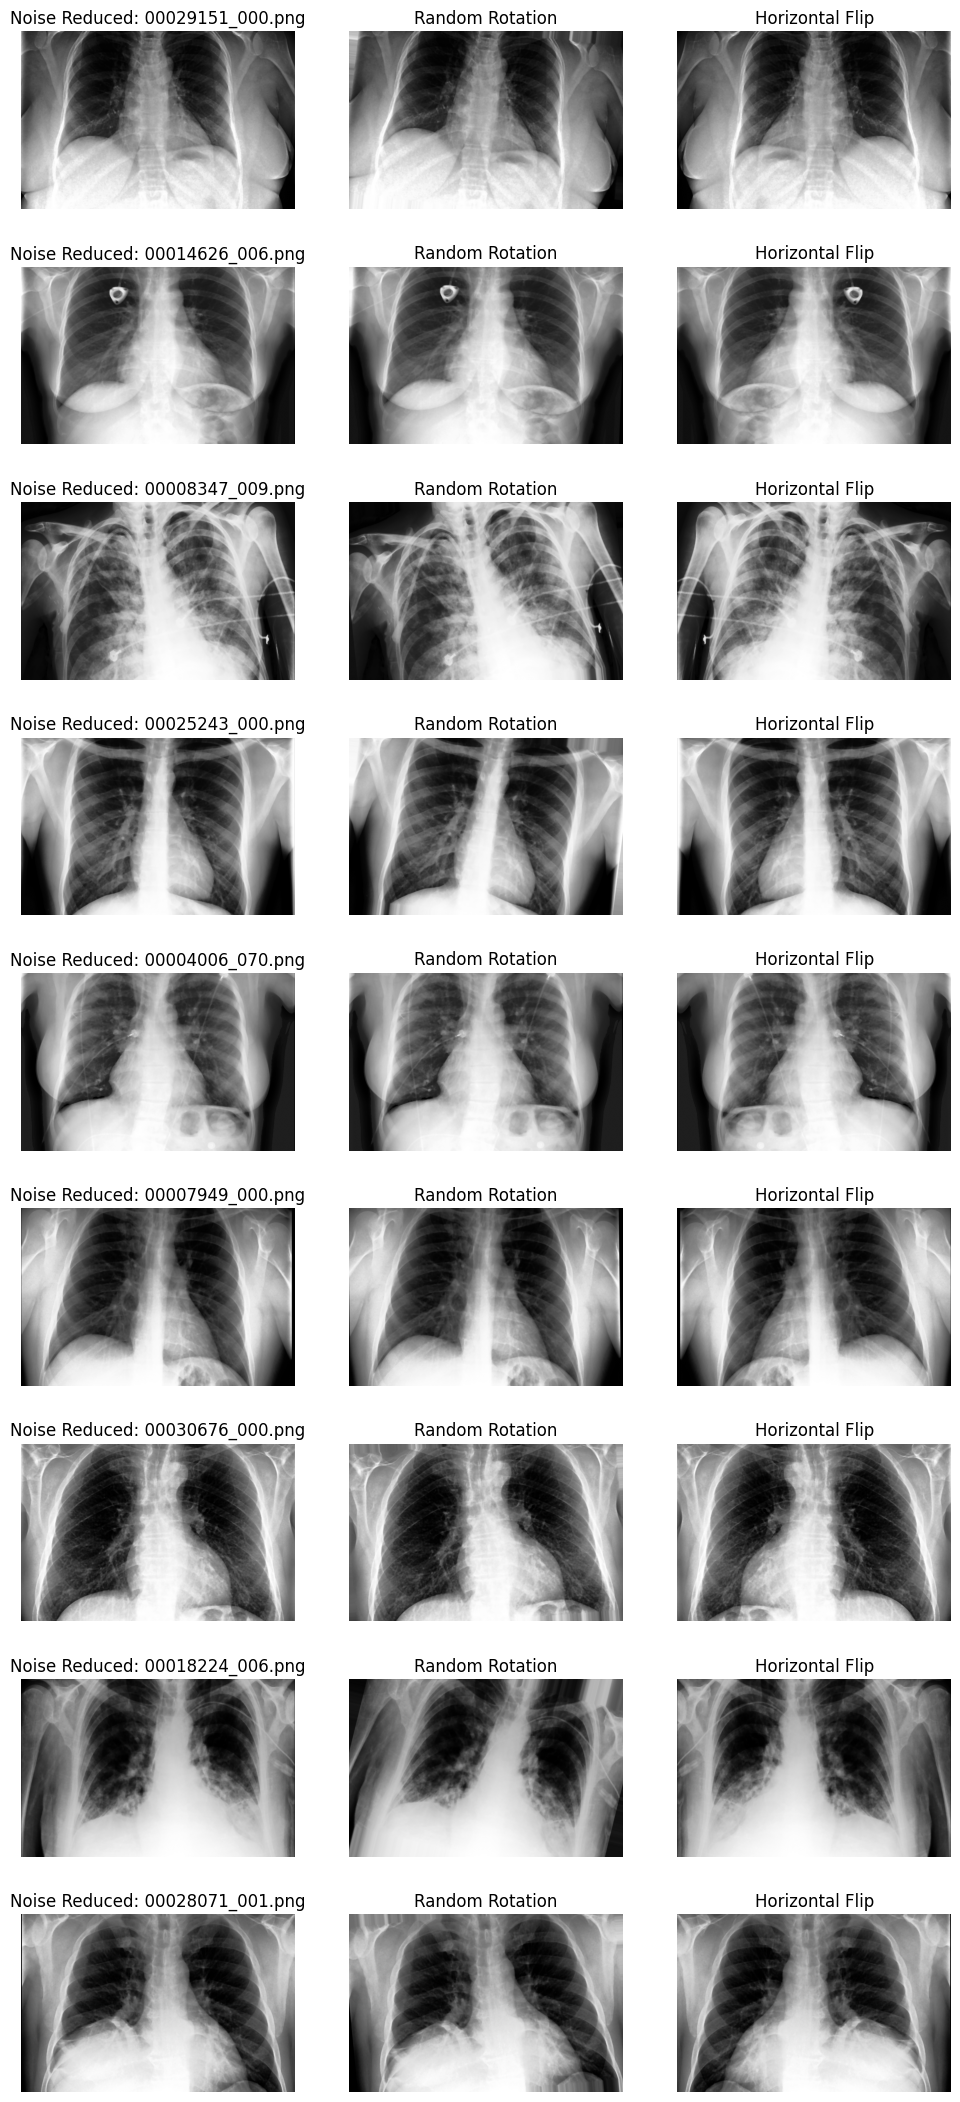

In [ ]:
# Dönüştürülen görselleri bir sonraki adım için saklamak üzere sözlük
transformed_images = {}

def random_rotation(image, angle_range=(-15, 15)):

    h, w = image.shape
    angle = random.uniform(angle_range[0], angle_range[1])
    matrix = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return rotated

def flip_image(image, flip_code=1):

    return cv2.flip(image, flip_code)

# Dönüşümlerle gürültü azaltılmış görüntüleri işlemek
num_images = len(noise_reduced_images)
plt.figure(figsize=(12, num_images * 3))

for i, (image_name, noise_reduced_image) in enumerate(noise_reduced_images.items()):
    # transformations
    rotated_image = random_rotation(noise_reduced_image)
    flipped_image = flip_image(noise_reduced_image, flip_code=1)

    # Dönüştürülen görüntüleri bir sonraki adım için kaydetmek
    transformed_images[image_name] = rotated_image


    plt.subplot(num_images, 3, 3 * i + 1)
    plt.imshow(noise_reduced_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Noise Reduced: {image_name}")

    plt.subplot(num_images, 3, 3 * i + 2)
    plt.imshow(rotated_image, cmap='gray')
    plt.axis('off')
    plt.title("Random Rotation")

    plt.subplot(num_images, 3, 3 * i + 3)
    plt.imshow(flipped_image, cmap='gray')
    plt.axis('off')
    plt.title("Horizontal Flip")

plt.show()


 **Görüntü Dönüşümü (Image Transformation)**  

Amaç:
*   Derin öğrenme modellerinde daha iyi genelleme sağlamak için görüntüleri artırmak.
*   Veri kümesinin çeşitliliğini artırmak için rastgele döndürme ve yansıtma işlemleri uygulamak.
  
Kullanılan Teknikler:  
1. Rastgele Döndürme (Random Rotation):Görüntüleri rastgele ±15 derece döndürür.  
2. Yatay Çevirme (Horizontal Flipping):Görüntüyü yatay olarak yansıtır.  

Neden Bu Dönüşümler Kullanıldı?

*   Döndürme, modelin belirli yönlere olan bağımlılığını azaltmaya yardımcı olur.
*   Yansıtma, modelin akciğer yapılarını sol-sağ simetrisiyle öğrenmesini sağlar.

Gözlemler:
*   Döndürme ve yansıtma işlemleri veri kümesini başarılı bir şekilde artırdı.
*   Bazı görüntülerde hafif hizalama hataları oluştu, ancak bu kabul edilebilir düzeyde.

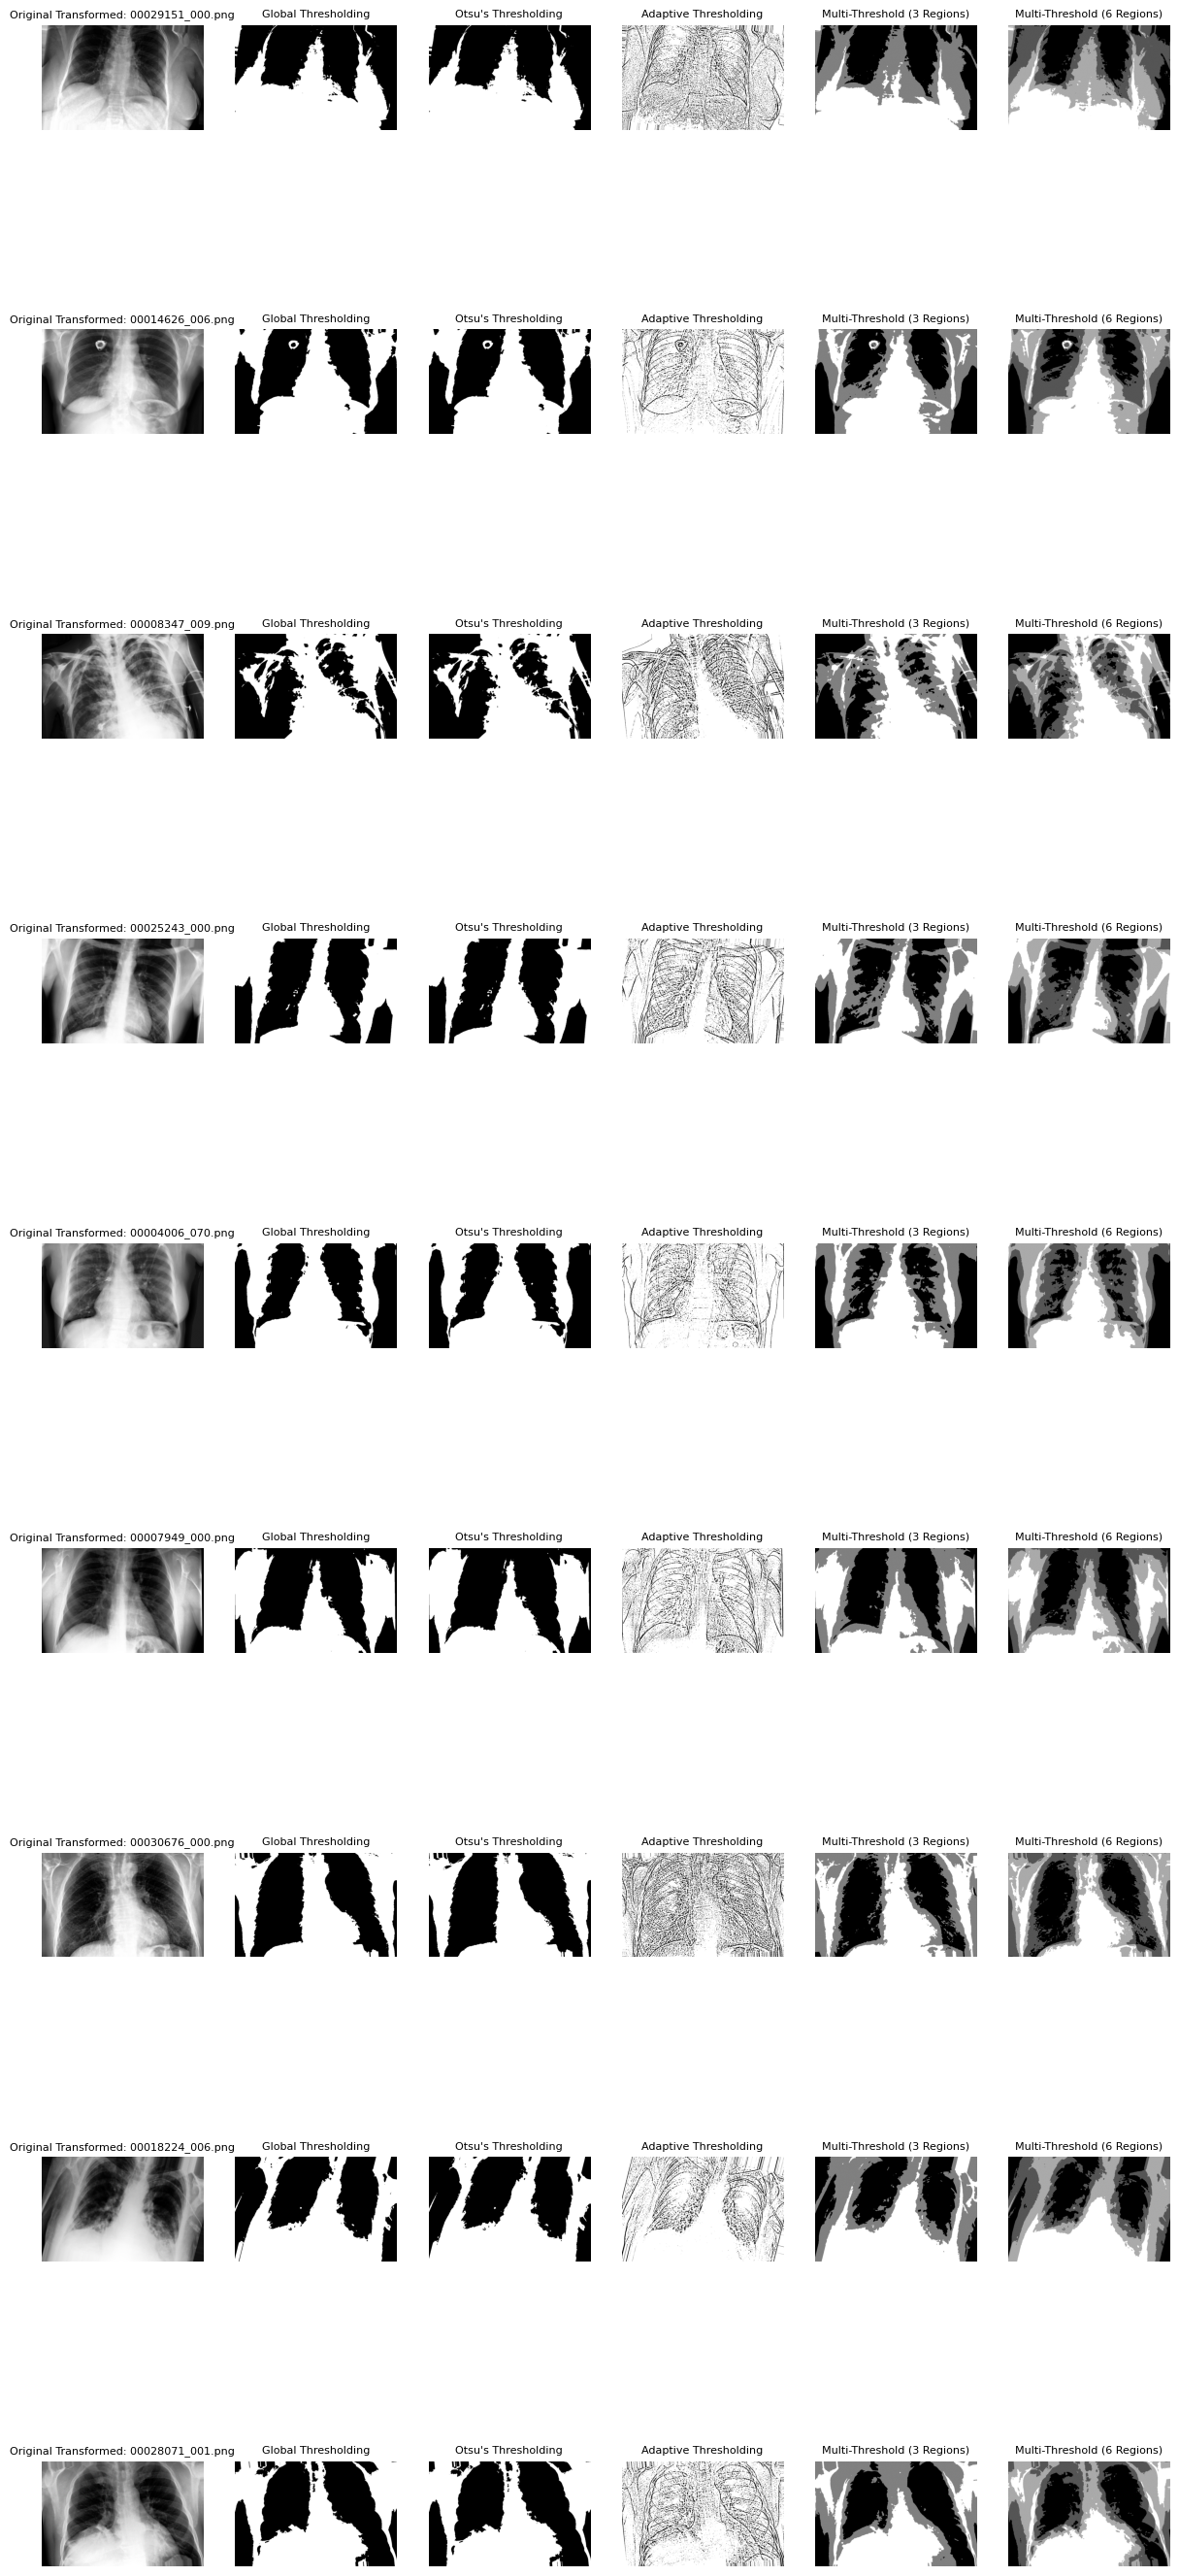

In [ ]:
# Dönüştürülmüş görüntüleri farklı eşikleme yöntemleriyle işlemek
num_images = len(transformed_images)
plt.figure(figsize=(15, num_images * 4))

for i, (image_name, transformed_image) in enumerate(transformed_images.items()):
    # Gaussian Density Transformation
    gaussian_image = gaussian(transformed_image, sigma=2) * 255

    # Global Thresholding (Fixed)
    _, global_thresh_image = cv2.threshold(transformed_image, 127, 255, cv2.THRESH_BINARY)

    # Otsu’s Thresholding (Automatic)
    otsu_thresh = threshold_otsu(transformed_image)
    otsu_thresh_image = transformed_image > otsu_thresh
    otsu_thresh_image = (otsu_thresh_image * 255).astype(np.uint8)

    # Adaptive Thresholding
    adaptive_thresh_image = cv2.adaptiveThreshold(
        transformed_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Multi-Threshold Segmentation (3 Bölge)
    thresholds_2 = threshold_multiotsu(transformed_image, classes=3)
    multi_thresh_image_2 = np.digitize(transformed_image, bins=thresholds_2) * (255 // len(thresholds_2))

    # Multi-Threshold Segmentation (4 Bölge)
    thresholds_4 = threshold_multiotsu(transformed_image, classes=4)
    multi_thresh_image_4 = np.digitize(transformed_image, bins=thresholds_4) * (255 // len(thresholds_4))



    plt.subplot(num_images, 6, 6 * i + 1)
    plt.imshow(transformed_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Original Transformed: {image_name}", fontsize=8)

    plt.subplot(num_images, 6, 6 * i + 2)
    plt.imshow(global_thresh_image, cmap='gray')
    plt.axis('off')
    plt.title("Global Thresholding", fontsize=8)

    plt.subplot(num_images, 6, 6 * i + 3)
    plt.imshow(otsu_thresh_image, cmap='gray')
    plt.axis('off')
    plt.title("Otsu's Thresholding", fontsize=8)

    plt.subplot(num_images, 6, 6 * i + 4)
    plt.imshow(adaptive_thresh_image, cmap='gray')
    plt.axis('off')
    plt.title("Adaptive Thresholding" , fontsize=8)

    plt.subplot(num_images, 6, 6 * i + 5)
    plt.imshow(multi_thresh_image_2, cmap='gray')
    plt.axis('off')
    plt.title("Multi-Threshold (3 Regions)", fontsize=8)

    plt.subplot(num_images, 6, 6 * i + 6)
    plt.imshow(multi_thresh_image_4, cmap='gray')
    plt.axis('off')
    plt.title("Multi-Threshold (6 Regions)", fontsize=8)

plt.show()



**Eşikleme (Thresholding)**  

Amaç:
Röntgen görüntülerinden akciğer bölgelerini segmentlemek.  

Kullanılan Teknikler:  
1. Global Eşikleme (Global Thresholding)
2. Otsu’nun Eşikleme Yöntemi (Otsu’s Thresholding)  
3. Uyarlanabilir Eşikleme (Adaptive Thresholding)  
4. Çoklu Eşikleme Segmentasyonu (Multi-Threshold Segmentation - 3 ve 4 Bölge)  

Neden Çoklu Eşikleme (4 Bölge) Seçildi?
*   Akciğer bölgeleri ve arka planı daha iyi ayırdı.
*   Global ve Otsu yöntemleri çok basit kaldı.
*   Uyarlanabilir eşikleme, görüntüler arasında tutarsız sonuçlar verdi.

Gözlemler:
*   Çoklu Eşikleme (4 Bölge), akciğer segmentasyonu için en iyi sonucu verdi.


In [ ]:
# Çoklu Eşik (4 Bölge) sonuçlarını depolamak için sözlük
multi_threshold_4_results = {}

for image_name, transformed_image in transformed_images.items():
    # Çoklu Eşik Hesaplama (4 Bölge)
    thresholds_4 = threshold_multiotsu(transformed_image, classes=4)
    multi_thresh_image_4 = np.digitize(transformed_image, bins=thresholds_4) * (255 // len(thresholds_4))

    # Sözlükte saklamak
    multi_threshold_4_results[image_name] = multi_thresh_image_4

print(" Multi-Threshold (4 Regions) results saved successfully.")


 Multi-Threshold (4 Regions) results saved successfully.


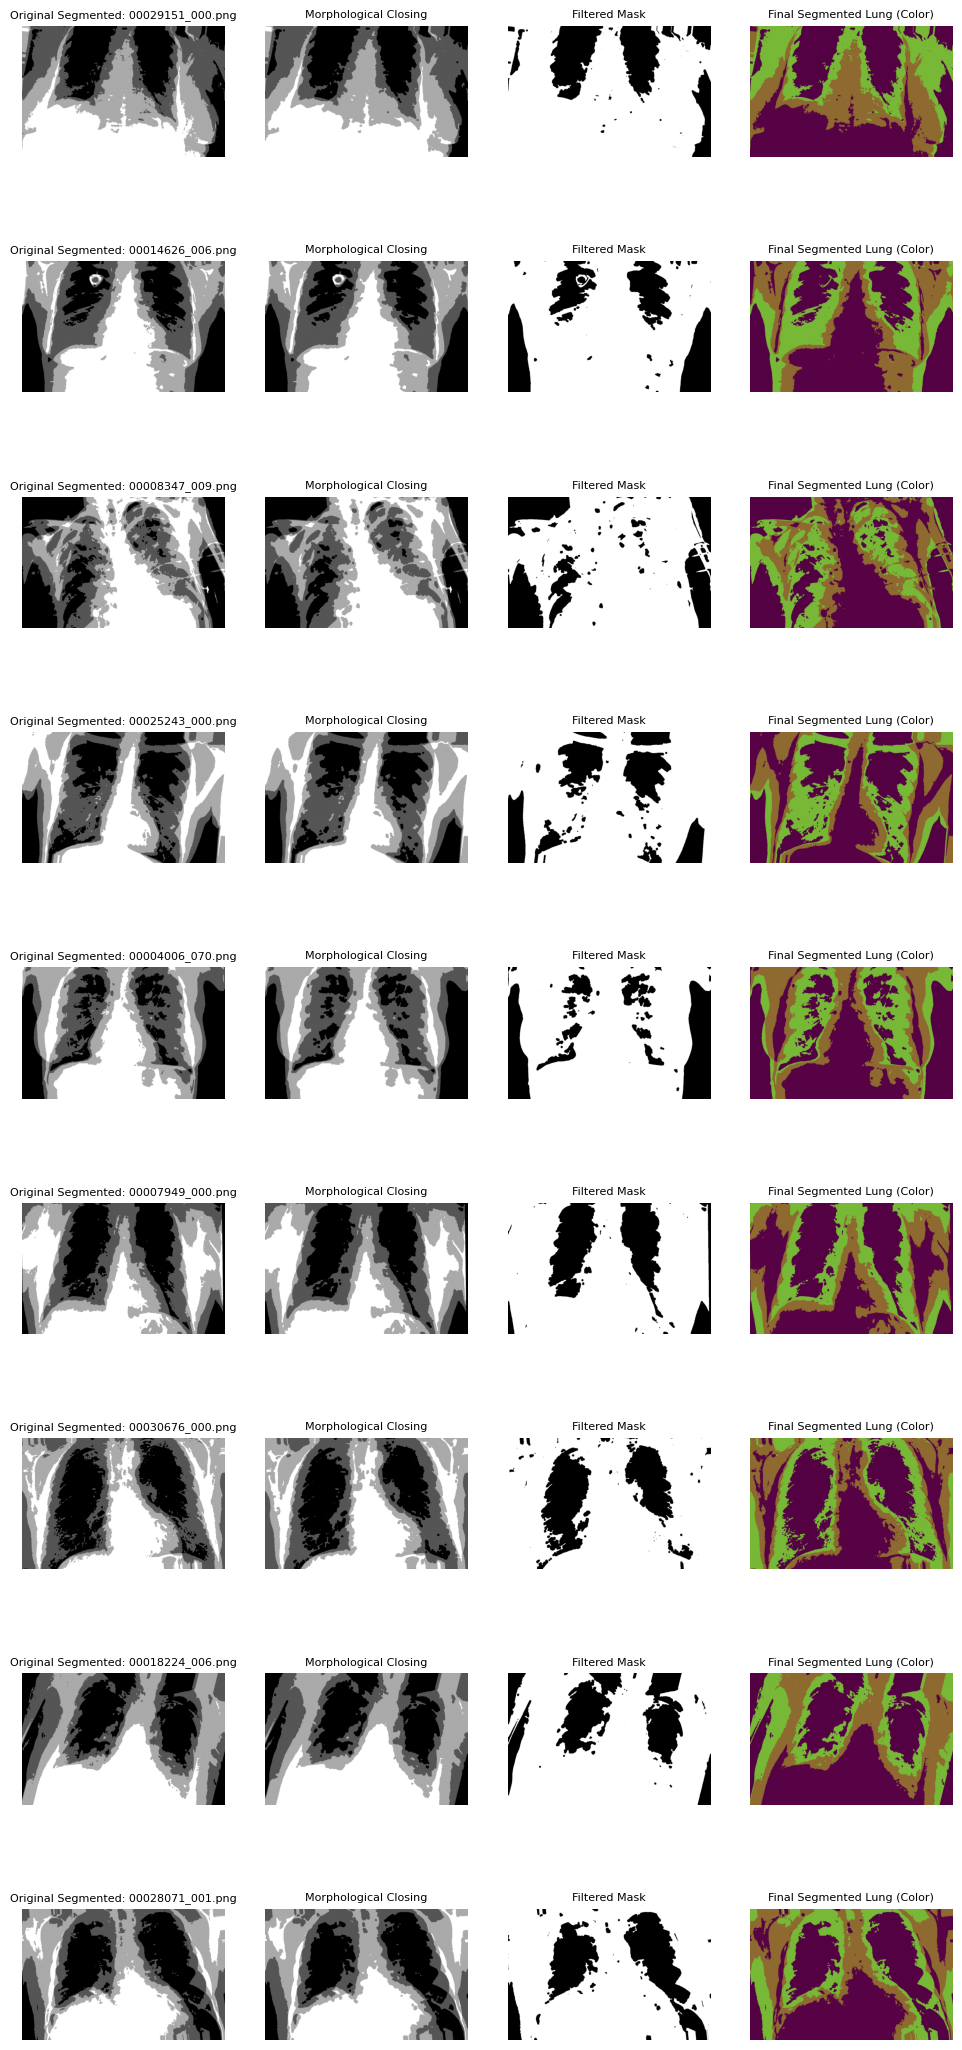

Post-processing completed with color visualization.


In [ ]:
# Sonradan işlenmiş sonuçları depolamak için sözlük
post_processed_results = {}

# Morfolojik işlemler için yapılandırma öğesini tanımak
selem = disk(5)

plt.figure(figsize=(12, len(multi_threshold_4_results) * 3))

for i, (image_name, segmented_image) in enumerate(multi_threshold_4_results.items()):
    # Step 1: Morphological Closing
    closed_image = closing(segmented_image, selem)

    # Step 2: Connected Component Labeling (CCL)
    labeled_mask = label(closed_image)

    # Step 3: Feature Extraction & Filtering
    filtered_mask = np.zeros_like(segmented_image)  # Initialize empty mask

    for region in regionprops(labeled_mask):
        if region.area > 1000:
            filtered_mask[labeled_mask == region.label] = 255

    # Step 4: Final Mask Application
    final_segmented_lung = np.multiply(filtered_mask, segmented_image)

    # uint8 biçimine dönüştürmek
    final_segmented_lung = np.uint8(final_segmented_lung)
    final_colored = cv2.applyColorMap(final_segmented_lung, cv2.COLORMAP_VIRIDIS)



    post_processed_results[image_name] = final_segmented_lung


    plt.subplot(len(multi_threshold_4_results), 4, 4 * i + 1)
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Original Segmented: {image_name}", fontsize=8)

    plt.subplot(len(multi_threshold_4_results), 4, 4 * i + 2)
    plt.imshow(closed_image, cmap='gray')
    plt.axis('off')
    plt.title("Morphological Closing", fontsize=8)

    plt.subplot(len(multi_threshold_4_results), 4, 4 * i + 3)
    plt.imshow(filtered_mask, cmap='gray')
    plt.axis('off')
    plt.title("Filtered Mask", fontsize=8)

    plt.subplot(len(multi_threshold_4_results), 4, 4 * i + 4)
    plt.imshow(final_colored)
    plt.axis('off')
    plt.title("Final Segmented Lung (Color)", fontsize=8)

plt.show()

print("Post-processing completed with color visualization.")


**Post-processing**

Amaç:  
Segmentasyonu iyileştirerek gürültüyü ve küçük yapay nesneleri kaldırmak.  

Kullanılan Teknikler:
1. Morfolojik Kapatma (Morphological Closing):Küçük boşlukları doldurur.  
2. Bağlı Bileşen Etiketleme (Connected Component Labeling - CCL): Küçük yanlış pozitifleri kaldırır.  
3. Son Maske Uygulaması (Final Mask Application).  

Neden Bu Yöntemler Kullanıldı?

*   Kapatma işlemi, akciğer bölgelerindeki boşlukları doldurur.
*   CCL, küçük yanlış segmentleri ortadan kaldırır.

Gözlemler:

*  Son işleme, segmentasyonun netliğini önemli ölçüde artırdı.


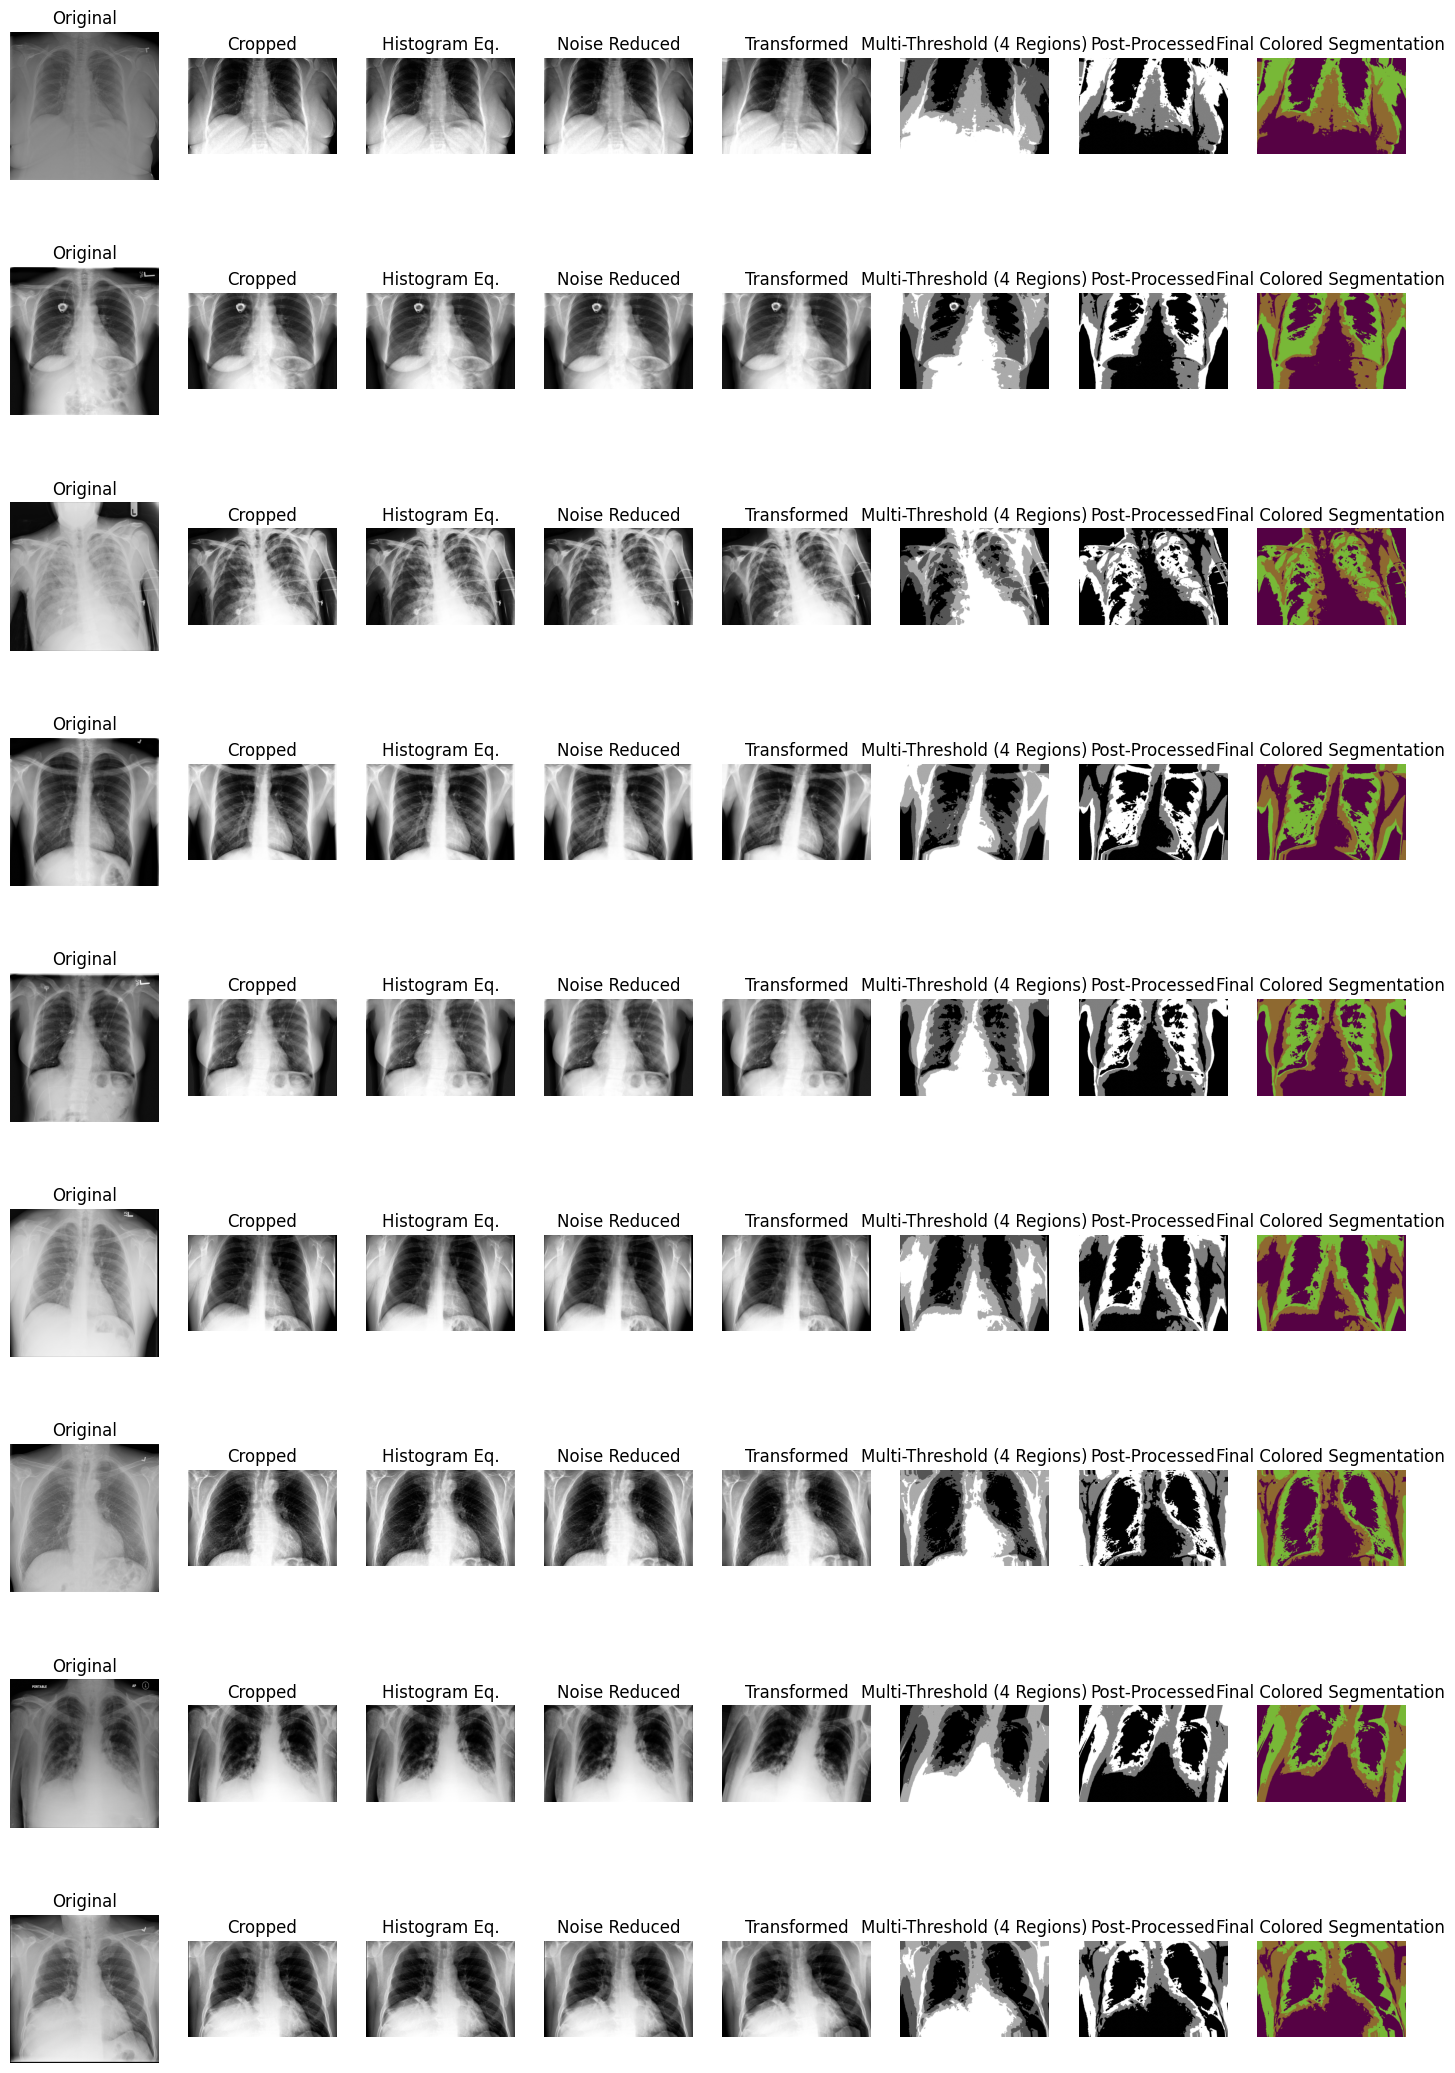

In [ ]:
# Görselleştirme için adımları tanımak
num_images = len(sample_images)
plt.figure(figsize=(18, num_images * 3))

for i, image_name in enumerate(sample_images):
    original = cv2.imread(os.path.join(images_folder_path, image_name), cv2.IMREAD_GRAYSCALE)
    cropped = hist_eq_images.get(image_name, None)
    hist_eq = hist_eq_images.get(image_name, None)
    noise_reduced = noise_reduced_images.get(image_name, None)
    transformed = transformed_images.get(image_name, None)
    multi_thresh = multi_threshold_4_results.get(image_name, None)
    post_processed = post_processed_results.get(image_name, None)


    if post_processed is not None:
        post_processed = np.uint8(post_processed)
        final_colored = cv2.applyColorMap(post_processed, cv2.COLORMAP_VIRIDIS)


    plt.subplot(num_images, 8, 8 * i + 1)
    plt.imshow(original, cmap='gray')
    plt.axis('off')
    plt.title("Original")

    plt.subplot(num_images, 8, 8 * i + 2)
    plt.imshow(cropped, cmap='gray')
    plt.axis('off')
    plt.title("Cropped")

    plt.subplot(num_images, 8, 8 * i + 3)
    plt.imshow(hist_eq, cmap='gray')
    plt.axis('off')
    plt.title("Histogram Eq.")

    plt.subplot(num_images, 8, 8 * i + 4)
    plt.imshow(noise_reduced, cmap='gray')
    plt.axis('off')
    plt.title("Noise Reduced")

    plt.subplot(num_images, 8, 8 * i + 5)
    plt.imshow(transformed, cmap='gray')
    plt.axis('off')
    plt.title("Transformed")

    plt.subplot(num_images, 8, 8 * i + 6)
    plt.imshow(multi_thresh, cmap='gray')
    plt.axis('off')
    plt.title("Multi-Threshold (4 Regions)")

    plt.subplot(num_images, 8, 8 * i + 7)
    plt.imshow(post_processed, cmap='gray')
    plt.axis('off')
    plt.title("Post-Processed")

    plt.subplot(num_images, 8, 8 * i + 8)
    plt.imshow(final_colored)
    plt.axis('off')
    plt.title("Final Colored Segmentation")

plt.show()
